<h1 style="text-align:center">Advanced Statistical Inference</h1>
<h1 style="text-align:center">Gaussian Process Regression</h1>

## 1. Aims
<div class="alert alert-info">
<ul> 
<li>To sample from a Gaussian process prior distribution.
<li>To implement Gaussian process inference for regression.
<li>To use the above to observe samples from a Gaussian process posterior distribution.
<li>To evaluate how different hyperparameter settings impact model quality.
<li> To investigate different kernel functions and parameter optimisation strategies.
</ul>
</div>

## 2. Introduction
<div class="alert alert-info">
Gaussian processes (henceforth GPs) achieve greater flexibility over parametric models by imposing a preference bias as opposed to restrictive constraints. Although the parameterisation of GPs allows one to access a certain (infinite) set of functions, preference can be expressed using a prior over functions. This allows greater freedom in representing data dependencies, thus enabling the construction of better-suited models. In this lab, we shall cover the basic concepts of GP regression. For the sake of clarity, we shall focus on univariate data, which allows for better visualisation of the GP model. Nonetheless, the code implemented within this lab can be very easily extended to handle
multi-dimensional inputs.
</div>

## 3. Sampling from the GP Prior
<div class="alert alert-info">
We shall consider a one-dimensional regression problem, whereby the inputs x are transformed by
a function $f(x) = sin(exp(0.03 * x))$. 
<br><br>
Generate 200 random points, $x$, in the range $[-20, 80]$, and compute their corresponding function
values, $t$. The target function can then be plotted accordingly.
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

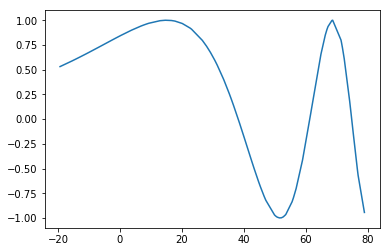

In [2]:
x=np.random.uniform(low=-20, high=80, size=(100,))
t=np.sin(np.exp(0.03*x))
indexes=np.argsort(x)

plt.plot(np.sort(x),t[indexes])

<div class="alert alert-info">
Recall that since GPs are non-parametric; we define a prior distribution over functions (models),
specified as a multivariate Gaussian distribution $p(f) = N (\mu, \Sigma)$.

Without loss of generality, we shall assume a zero-mean GP prior, i.e. $\mu = 0$. The covariance
matrix of the distribution, $\Sigma$, may then be computed by evaluating the covariance between the
input points. For this tutorial, we shall consider the widely used squared-exponential (RBF)
covariance (also referred to as the kernel function), which is defined between two points as: 

$$k(x, x') = \sigma_f^2 \exp \Big( -\dfrac {(x-x')^2}{2l^2} \Big). $$

This kernel is parameterised by a lengthscale parameter $l$, and variance $\sigma_f^2$ . Given that the true
function may be assumed to be corrupted with noise, we can also add a noise parameter, $\sigma_n^2$ , to
the diagonal entries of the resulting kernel matrix, $K$, such that

$$K_y = K + \sigma_n^2I.$$
<br>
Complete the `compute_kernel()` function for computing the RBF kernel $K$ between two sets of input points.<br><br>

Hint: The ‘cdist’ function in scipy can be used for evaluating the pairwise Euclidean distance between two sets of points.
</div>


In [3]:
def compute_kernel(x1, x2, lengthscale, variance):
    x1=np.tile(x1,(x2.size,1)).T
    x2=np.tile(x2,(x1.shape[0],1))
    return variance*np.exp(np.divide(-np.power((x1-x2),2),2*lengthscale**2))


<div class="alert alert-info">
Assuming a zero-mean prior, and using the kernel matrix constructed with `compute_kernel()` for input points x, we can sample from the prior distribution using the numpy `multivariate_normal()` function.<br><br>

For the time being, you can initialise the kernel parameters as follows:
<br>
- lengthscale = 10<br>
- variance = 0.1
</div>

In [4]:
mu = np.zeros(x.size)
K = compute_kernel(x,x,10,0.1)
R = np.random.multivariate_normal(np.zeros(K.shape[0]),K,4) 

<div class="alert alert-info">
On the same figure where we plotted the true function, draw four sample functions from the prior distribution and plot them accordingly.
</div>

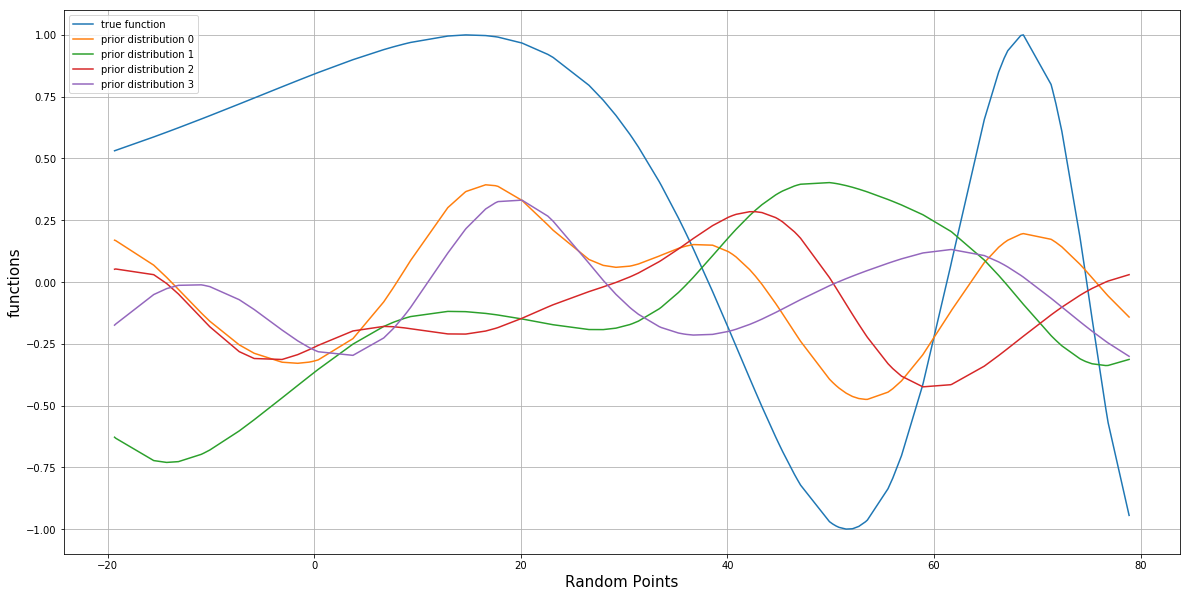

In [15]:
handles=[]
plt.figure(figsize=(20,10))
plt.plot(np.sort(x),t[indexes],label='true function')
handles.append(ax)
for i in range(R.shape[0]):
    plt.plot(np.sort(x),R[i][indexes],label='prior distribution '+str(i))
    handles.append(ax)
plt.xlabel("Random Points",fontsize=15)
plt.ylabel("functions",fontsize=15)
plt.grid()
plt.legend()
plt.show()



<div class="alert alert-info">
 In order to better understand the role of the hyperparameters, observe how altering the kernel parameters impacts the shape of the prior samples.</div>

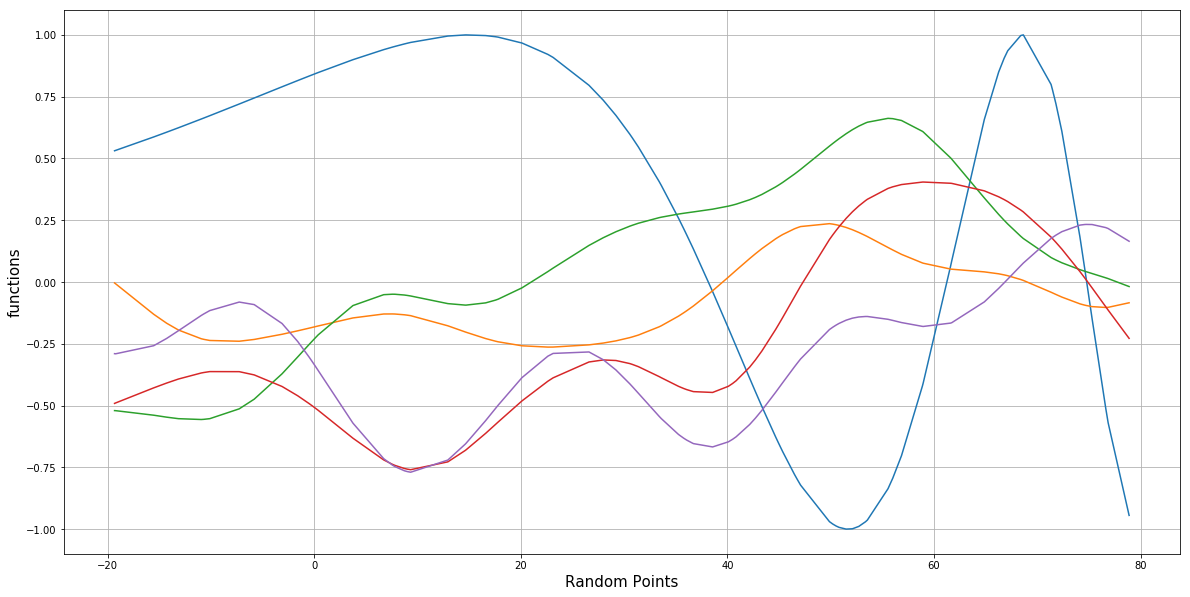

In [25]:
mu = np.zeros(x.size)
K = compute_kernel(x,x,10,0.1)
R = np.random.multivariate_normal(np.zeros(K.shape[0]),K,4)
plt.figure(figsize=(20,10))
plt.plot(np.sort(x),t[indexes])
for i in range(R.shape[0]):
    plt.plot(np.sort(x),R[i][indexes])
plt.xlabel("Random Points",fontsize=15)
plt.ylabel("functions",fontsize=15)
plt.grid()
plt.show()



Increasing the lengthscale will decrease oscillations and increasing the variance will increase the varinace of the of the priors.

## 4. GP Inference
<div class="alert alert-info">
Recall that the prior represents our prior beliefs before observing the function values of any data points. Suppose we can now observe 3 points at random from the input data; we would expect that with this additional knowledge, the functions drawn from the updated GP distribution would be constrained to pass through these points (or at least close if corrupted with noise). The combination of the prior and the likelihood of the observed data leads to the posterior distribution over functions.
<br><br>
Assign 3 points at random from $x$ (and their corresponding function values) to `obs_x` and `obs_t`
respectively. For now we shall assume that all other $x$ values are unobserved.<br><br>

You are encouraged to use the given initial configuration.
</div>

In [28]:
lengthscale = 10
variance = 0.1
noise = 1e-3

params = [lengthscale, variance, noise]

In [29]:
numObs = 10
obs_x = np.random.choice(x, numObs, replace=False)
obs_t = np.sin(np.exp(0.03*obs_x))

<div class="alert alert-info">

Complete the provided implementation of `gp_inference` for evaluating the posterior GP mean and variance using the equations given in the lecture.
<br><br>
<b>Note</b>: As we have encountered in previous labs, matrix inversions can be both numerically troublesome and slow to compute. In this lab, we shall avoid computing matrix inversions directly by instead considering Cholesky decompositions for solving linear systems. You are encouraged to read more about Cholesky decompositions for GPs by consulting Appendix A.4 of <a target="_blank" href="http://www.gaussianprocess.org/gpml/">Gaussian Processes for Machine Learning (Rasmussen and Williams, 2005)</a> - available online!<br><br>

The complete pseudo-code for the following procedure is provided in Algorithm 2.1 from Chapter 2 of this same book.
</div>

In [30]:
from scipy import array, linalg, dot
from scipy.linalg import solve_triangular
def gp_inference(obs_x, obs_t, x_new, params):
    
    # unpack params
    lengthscale = params[0]
    variance = params[1]
    noise = params[2]
    
    N = np.shape(obs_x)[0]
    
    # compute kernel
    
    K = compute_kernel(obs_x,obs_x,lengthscale,variance) 
    K_y=K+noise*np.eye(N)
    
    '''
    
    When computing the posterior mean, we would like to avoid evaluating
        
                            alpha = np.linalg.inv(K_y).dot(obs_t) 
    
    directly. The Cholesky decomposition can be applied using the following procedure.
    
        -> Compute the lower triangular Cholesky decomposition of K_y (which we shall call K_chol)
        -> Compute 'alpha' as:
        
                            alpha = K_chol.T \ (K_chol \ obs_t)
                            
           where the back-substitution operator can be evaluated using the 'solve_triangular' 
           function in scipy. Make sure to set the function's lower' flag as appropriate.
            
    
    '''
    
   
    # compute the Cholesky decomposition of K_y
    K_chol =  linalg.cholesky(K_y, lower=True)

    # compute alpha
    alpha = solve_triangular(K_chol.T,solve_triangular(K_chol, obs_t, lower=True),lower=True)
    
    # compute the covariance between the training and test data
    K_obs_pred = compute_kernel(obs_x,x_new,lengthscale,variance)
    
    # compute the covariance for the test data
    K_pred = compute_kernel(x_new,x_new,lengthscale,variance)
    
    # compute the posterior mean
    posterior_m = np.dot(K_obs_pred.T, alpha)
    
    
    '''
    
    Similarly, when computing
    
                        v = np.linalg.inv(kern_obs)*kern_obs_pred
                        
    employ the Cholesky decomposition as outlined above.
                        
    '''
    
    v = solve_triangular(K_chol.T,solve_triangular(K_chol,K_obs_pred, lower=True))
    posterior_v = K_pred-np.dot(K_obs_pred.T,v)
    
    
    return posterior_m, posterior_v

## 5. Sampling from the  GP Posterior<br>

<div class="alert alert-info">
Now that you have computed the posterior mean and variance, create a new figure once again showing the true function. To this figure, add the posterior mean and uncertainty (show two standard deviations) evaluated on the same $x$ values.
</div>

<div class="alert alert-info"> xnew should be seperated from obs_x.</div>

In [42]:
xnew=np.delete(x,obs_x)
posterior_m, posterior_v = gp_inference(obs_x,obs_t,xnew,params) # TO COMPLETE
R2 = np.random.multivariate_normal(posterior_m,posterior_v) 


'''

The variance at each point is given by the diagonal of the variance matrix.
Recall that the standard deviation is the square root of the variance.

'''

posterior_std =np.sqrt(np.diagonal(posterior_v))  # TO COMPLETE


C:\Users\Alaa Boukhary\Anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  """Entry point for launching an IPython kernel.
C:\Users\Alaa Boukhary\Anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  """Entry point for launching an IPython kernel.


In [43]:
xnew.shape

(92,)

IndexError: index 92 is out of bounds for axis 1 with size 92

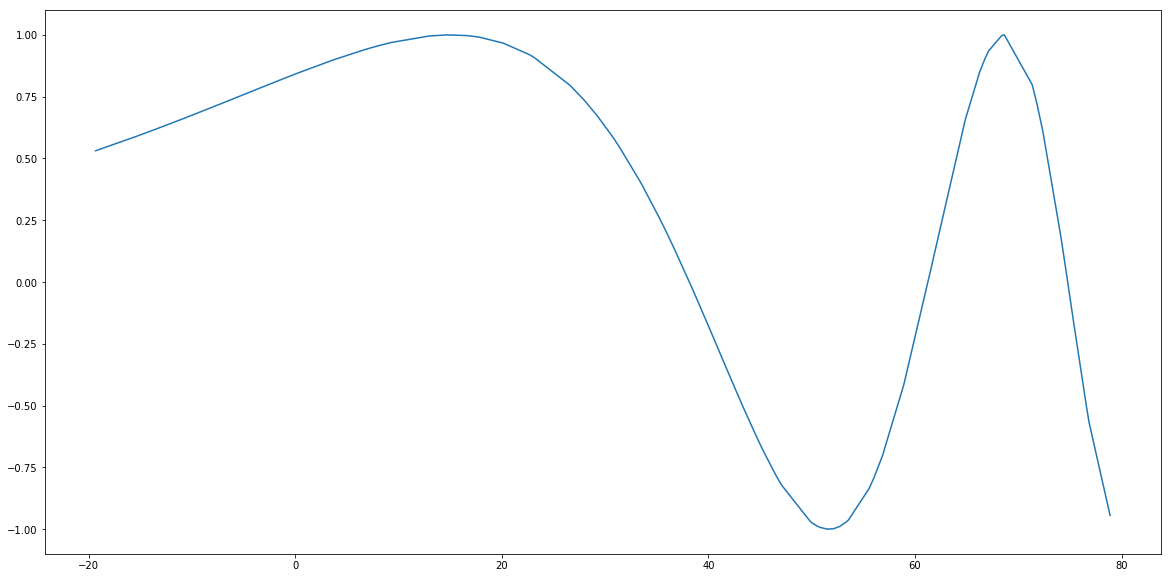

In [45]:
'''

Plot the results using error bars in order to display the posterior uncertainty.

TO COMPLETE

'''
indexes=np.argsort(x)
plt.figure(figsize=(20,10))
plt.plot(np.sort(x),t[indexes])
plt.errorbar(np.sort(xnew),posterior_m[indexes],yerr=posterior_std)
plt.xlabel("Random Points",fontsize=15)
plt.ylabel("functions",fontsize=15)
plt.grid()
plt.show()

<div class="alert alert-info">

Note that we should also add the noise variance to the predictive variance of the posterior. Fix this accordingly.
</div>

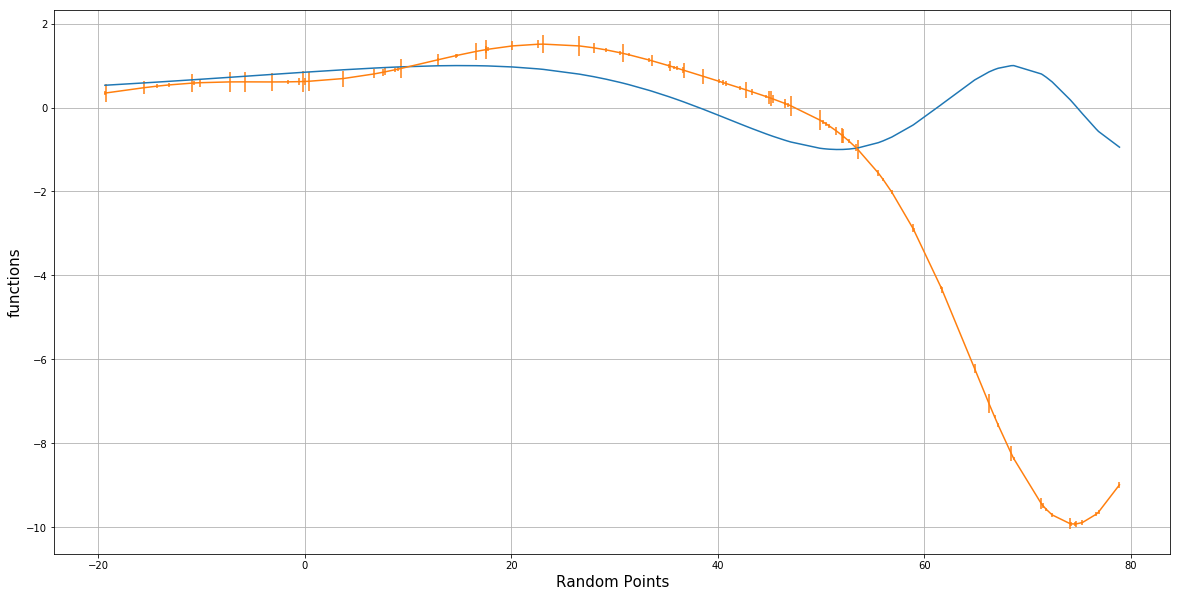

In [33]:
'''

TO COMPLETE

'''

R2 = np.random.multivariate_normal(posterior_m,posterior_v+noise) 


'''

The variance at each point is given by the diagonal of the variance matrix.
Recall that the standard deviation is the square root of the variance.

'''

posterior_std =np.sqrt(np.diagonal(posterior_v+noise))  # TO COMPLETE
'''

Plot the results using error bars in order to display the posterior uncertainty.

TO COMPLETE

'''
indexes=np.argsort(x)
plt.figure(figsize=(20,10))
plt.plot(np.sort(x),t[indexes])
plt.errorbar(np.sort(x),posterior_m[indexes],yerr=posterior_std)
plt.xlabel("Random Points",fontsize=15)
plt.ylabel("functions",fontsize=15)

plt.grid()
plt.show()

<div class="alert alert-info">

Additionally, as we did with the prior distribution, sample four functions from the posterior and plot them on the same figure. Comment on the obtained plots. You should also view how the posterior mean and variance change when more observations are treated as observations in the GP inference procedure.
</div>

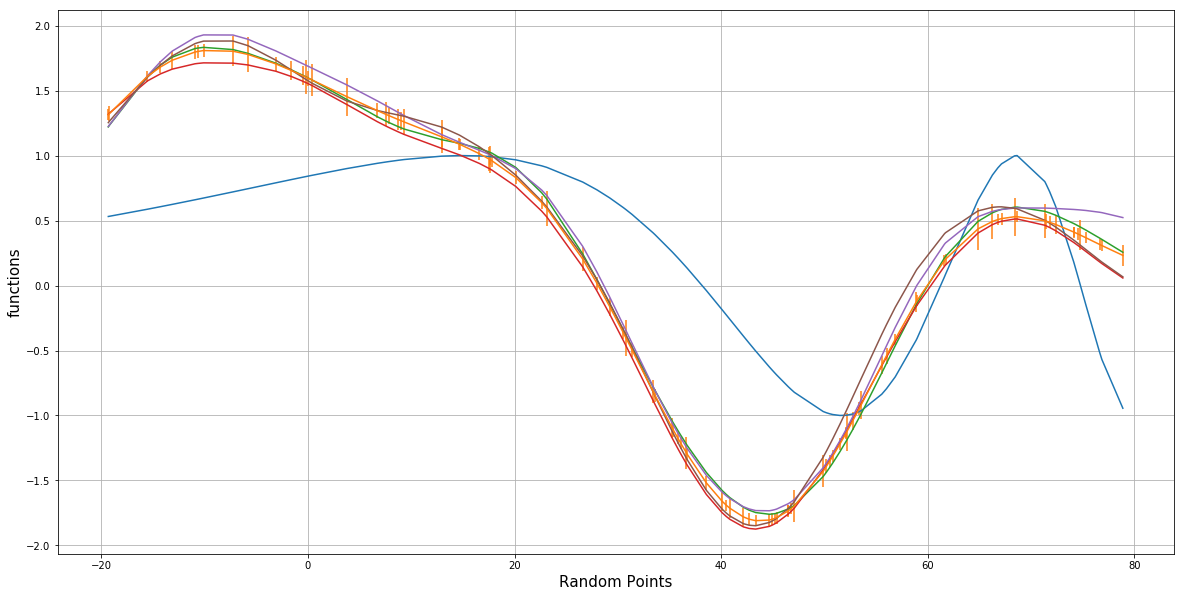

In [39]:
'''

TO COMPLETE

'''
numObs = 10
obs_x = np.random.choice(x, numObs, replace=False)
obs_t = np.sin(np.exp(0.03*obs_x))
posterior_m, posterior_v = gp_inference(obs_x,obs_t,x,params) # TO COMPLETE
R2 = np.random.multivariate_normal(posterior_m,posterior_v+noise,4) 


'''

The variance at each point is given by the diagonal of the variance matrix.
Recall that the standard deviation is the square root of the variance.

'''

posterior_std =np.sqrt(np.diagonal(posterior_v+noise))  # TO COMPLETE

indexes=np.argsort(x)
plt.figure(figsize=(20,10))
plt.plot(np.sort(x),t[indexes])
plt.errorbar(np.sort(x),posterior_m[indexes],yerr=posterior_std)
plt.xlabel("Random Points",fontsize=15)
plt.ylabel("functions",fontsize=15)
for i in range(R2.shape[0]):
    plt.plot(np.sort(x),R2[i][indexes])
plt.grid()
plt.show()




<div class="alert alert-info">
As a measure of model quality, you should also compute the log marginal likelihood of the model.
To this end, complete the code provided in `gp inference()` to include the negative log likelihood term.
<br><br>
You could attempt a grid search over a range of parameter values in order to determine which configuration yields the best result.<br><br>

Hint: Once again, refer to Algorithm 2.1 in Chapter 2 of the book referenced above for details on how to compute this term
efficiently.
</div>

In [141]:
from scipy import array, linalg, dot
from scipy.linalg import solve_triangular
import math
def gp_inference(obs_x, obs_t, x_new, params):
    
    # unpack params
    lengthscale = params[0]
    variance = params[1]
    noise = params[2]
    
    N = np.shape(obs_x)[0]
    
    # compute kernel
    
    K = compute_kernel(obs_x,obs_x,lengthscale,variance) 
    #K_y = compute_kernel(obs_x,obs_x,lengthscale,variance)
    K_y=K+noise*np.eye(N)
    
    '''
    
    When computing the posterior mean, we would like to avoid evaluating
        
                            alpha = np.linalg.inv(K_y).dot(obs_t) 
    
    directly. The Cholesky decomposition can be applied using the following procedure.
    
        -> Compute the lower triangular Cholesky decomposition of K_y (which we shall call K_chol)
        -> Compute 'alpha' as:
        
                            alpha = K_chol.T \ (K_chol \ obs_t)
                            
           where the back-substitution operator can be evaluated using the 'solve_triangular' 
           function in scipy. Make sure to set the function's lower' flag as appropriate.
            
    
    '''
    
   
    # compute the Cholesky decomposition of K_y
    K_chol =  linalg.cholesky(K_y, lower=True)

    # compute alpha
    alpha = solve_triangular(K_chol.T,solve_triangular(K_chol, obs_t, lower=True),lower=True)
    
    # compute the covariance between the training and test data
    K_obs_pred = compute_kernel(obs_x,x_new,lengthscale,variance)
    
    # compute the covariance for the test data
    K_pred = compute_kernel(x_new,x_new,lengthscale,variance)
    
    # compute the posterior mean
    posterior_m = np.dot(K_obs_pred.T, alpha)
    
    
    '''
    
    Similarly, when computing
    
                        v = np.linalg.inv(kern_obs)*kern_obs_pred
                        
    employ the Cholesky decomposition as outlined above.
                        
    '''
    
    v = solve_triangular(K_chol.T,solve_triangular(K_chol,K_obs_pred, lower=True))
    posterior_v = K_pred-np.dot(K_obs_pred.T,v)
    
    
    Kt=K+noise*np.eye(K.shape[0])
    K_chol =  linalg.cholesky(Kt, lower=True)

    # compute alpha
    alpha = solve_triangular(K_chol.T,solve_triangular(K_chol, obs_t, lower=True),lower=True)
    
    log_likelihood=-math.log(np.linalg.det(Kt))-np.dot(obs_t,alpha)
    
    return posterior_m, posterior_v,log_likelihood

In [150]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
lengthscales = [0.1,1,10]
variances = [0.1,1,10]
noises = [1e-3, 1e-2, 0.1]

results=[]
used_parameters=[]
likelihood=np.zeros((10,))
 
for lengthscale in lengthscales:
    for variance in variances:
        for noise in noises:
            params=[lengthscale,variance,noise]
            for i in range(10):
                
                X_train, X_test, y_train, y_test = train_test_split(x, t, test_size=0.2, random_state=0)
                posterior_m, posterior_v,likelihood[i] = gp_inference(X_train,y_train,X_test,params)
            results.append(np.mean(likelihood))
            used_parameters.append({'lengthscale': lengthscale,'variance': variance,'noise': noise})
print("the maximum likelihood",np.max(results))
print("the best parameters used are :",used_parameters[np.argmax(results)])
            
            




the maximum likelihood 403.76668856487913
the best parameters used are : {'lengthscale': 10, 'variance': 10, 'noise': 0.001}


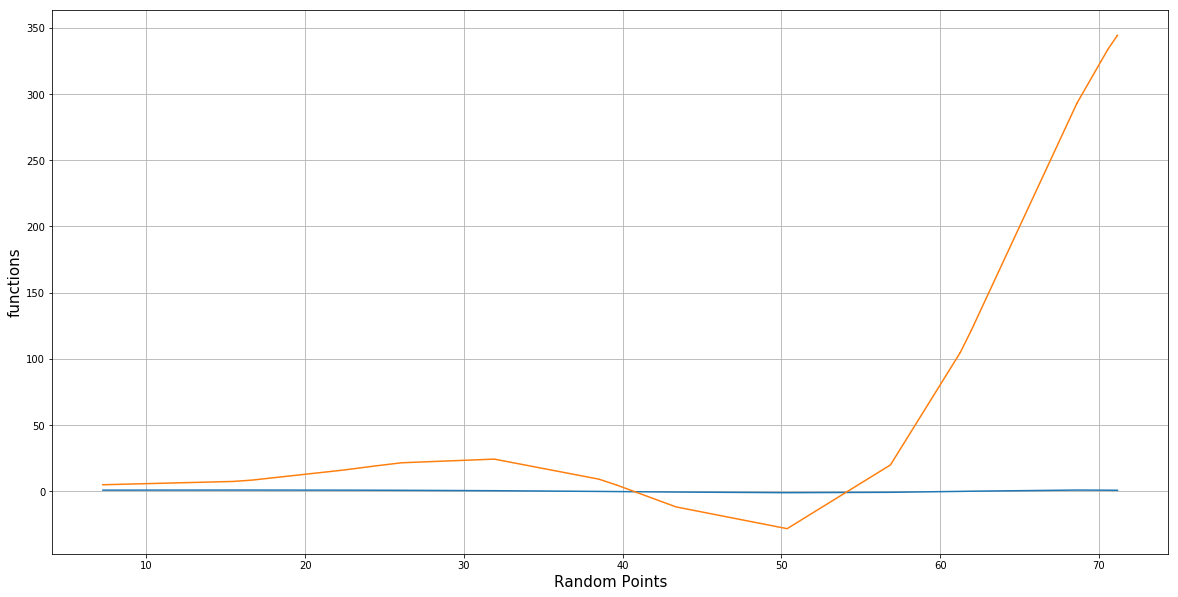

In [162]:

  # TO COMPLETE
posterior_m, posterior_v,likelihood[i] = gp_inference(X_train,y_train,X_test,[10,10,0.001])
posterior_std =np.sqrt(np.diagonal(posterior_v+noise))



indexes=np.argsort(X_test)
plt.figure(figsize=(20,10))
plt.plot(np.sort(X_test),y_test[indexes])
plt.errorbar(np.sort(X_test),posterior_m[indexes],yerr=posterior_std[indexes])
plt.xlabel("Random Points",fontsize=15)
plt.ylabel("functions",fontsize=15)

plt.grid()
plt.show()

## Bonus: Alternative Kernel Functions
<div class="alert alert-info">
In this notebook, we have focused exclusively on the RBF kernel.
However, the choice of kernel function (along with its associated parameters) can have a significant effect on the overall Gaussian process model.
Choosing the best kernel to fit your data is no simple task, and is a pertinent problem in many applied domains.<br>

A brief discussion on this problem may be found here: <a target="_blank" href="https://www.cs.toronto.edu/~duvenaud/cookbook/">Kernel Cookbook</a>. 

Familiarise yourself better with these issues by implementing one or two additional kernels.
The effectiveness of each kernel may then be easily evaluated by simply overriding the previously defined `compute_kernel()` function.
As a further step, you could also extend this comparison to other test functions besides the one being used in this exercise.

In [ ]:
'''

TO COMPLETE

'''

## Bonus: Parameter Optimisation using Gradient Descent
<br>
<div class="alert alert-info">
Optimise the hyperparameters of the model by minimising the negative log-likelihood of the model. For a complete solution, you should include the derivatives of the objective function with respect to the parameters being optimised.
<br><br>
The general formula for computing the derivative is given below:<br>
$$
\frac{\partial\;\text{NLL}}{\partial\;\theta_i} = - \frac{1}{2} \textbf{Tr} \left( K^{-1} \frac{\partial K}{\partial \theta_i} \right) + \frac{1}{2} \textbf{y}^{T} K^{-1} \frac{\partial K}{\partial \theta_i} K^{-1} \textbf{y}.
$$<br>
To give a more concrete example, the $\frac{\partial K}{\partial \theta_i}$ term for the lengthscale parameter in the RBF kernel is computed as follows:
$$
\frac{\partial K}{\partial l} = \sigma_f^2 \exp \left( -\dfrac {(x-x')^2}{2l^2} \right)\left( \dfrac {(x-x')^2}{l^3} \right)
$$
<br><br>
<b>Pro tip:</b> Note that the parameters $l$, $\sigma_f^2$ , and $\sigma_n^2$ are always expected to be positive. It is possible that the optimisation algorithm attempts to evaluate the log-likelihood in regions of the parameter space where one or more of these parameters are negative, leading to numerical issues. While not expected in this notebook, a commonly-used technique to enforce this condition is to work with a transformed version of covariance parameters using the logarithm transformation. In particular, define $\psi_l = log(l)$, $\psi_f = log(\sigma_f^2 )$, and $\psi_n = log(\sigma_n^2 )$, and optimise with respect to the $\psi$ parameters. The optimisation problem in the transformed space is now unbounded, and the gradient of the log-likelihood should be computed with respect to the $\psi$ parameters.
</div>

In [ ]:
'''

TO COMPLETE

'''